In [1]:
from termcolor import  cprint
import sys
import os
import json
import numpy as np
from PreprocessingObj import *
from PolygonSettings import *
import pandas as pd
from Hexagon import *
from Grid import *
from multiprocessing import Pool
import socket
if socket.gethostname()=='artemis.ist.berkeley.edu':
    sys.path.append(os.path.join('/home/alberto/test/LPSim','traffic_phase_transition','scripts','ServerCommunication'))
else:
    sys.path.append(os.path.join(os.getenv('TRAFFIC_DIR'),'scripts','ServerCommunication'))
from HostConnection import *

def AllStepsGrid(GeometricalInfo,grid_size,NameCity):
    GeometricalInfo.grid = GetGrid(grid_size,
                                    GeometricalInfo.bounding_box,
                                    GeometricalInfo.crs,
                                    GeometricalInfo.save_dir_local)
    GeometricalInfo.grid = GetGeometryPopulation(GeometricalInfo.gdf_hexagons,GeometricalInfo.grid,'grid',NameCity)
    GeometricalInfo.lattice = GetLattice(GeometricalInfo.grid,grid_size,GeometricalInfo.bounding_box,GeometricalInfo.save_dir_local)
    SaveGrid(GeometricalInfo.save_dir_local,grid_size,GeometricalInfo.grid)
    SaveLattice(GeometricalInfo.save_dir_local,grid_size,GeometricalInfo.lattice)
    GeometricalInfo.OD2grid,GeometricalInfo.grid2OD = Geometry2OD(gdf_geometry = GeometricalInfo.grid,
                                                                    GraphFromPhml = GeometricalInfo.GraphFromPhml,
                                                                    NameCity = GeometricalInfo.city,
                                                                    GeometryName ='grid',
                                                                    save_dir_local = GeometricalInfo.save_dir_local,
                                                                    resolution = grid_size)
    # ADD FILES TO UPLOAD
    GeometricalInfo.UpdateFiles2Upload(os.path.join(GeometricalInfo.save_dir_local,'grid',str(grid_size),'grid.geojson'),os.path.join(GeometricalInfo.save_dir_server,'grid',str(grid_size),'grid.geojson'))
    GeometricalInfo.UpdateFiles2Upload(os.path.join(GeometricalInfo.save_dir_local,'grid',str(grid_size),'grid2origindest.json'),os.path.join(GeometricalInfo.save_dir_server,'grid',str(grid_size),'grid2origindest.json'))
    GeometricalInfo.UpdateFiles2Upload(os.path.join(GeometricalInfo.save_dir_local,'grid',str(grid_size),'origindest2grid.json'),os.path.join(GeometricalInfo.save_dir_server,'grid',str(grid_size),'origindest2grid.json')) 
    GeometricalInfo.UpdateFiles2Upload(os.path.join(GeometricalInfo.save_dir_local,'grid',str(grid_size),'centroid_lattice.graphml'),os.path.join(GeometricalInfo.save_dir_server,'grid',str(grid_size),'centroid_lattice.graphml'))
    MakeDir(GeometricalInfo.save_dir_server,'grid')
    MakeDir(os.path.join(GeometricalInfo.save_dir_server,'grid'),str(grid_size))
    for file in GeometricalInfo.Files2Upload:
        Upload2ServerPwd(file,GeometricalInfo.Files2Upload[file],GeometricalInfo.config_dir_local)


def ComputeGrid(NameCity,TRAFFIC_DIR):
    print('Computing Grid for city: ',NameCity)
    print('TRAFFIC_DIR: ',TRAFFIC_DIR)
    GeometricalInfo = GeometricalSettingsSpatialPartition(NameCity,TRAFFIC_DIR)
    GeometricalInfo.gdf_hexagons = GetHexagon(GeometricalInfo.gdf_polygons,GeometricalInfo.tiff_file_dir_local,GeometricalInfo.save_dir_local,NameCity,8)
    grid_sizes = list(np.arange(0.01,0.1,0.01))
    ParametersGridParallel = [(GeometricalInfo,grid_size,NameCity) for grid_size in grid_sizes]
    with Pool(processes = 6) as pool:
        pool.starmap(AllStepsGrid,ParametersGridParallel)

if __name__=='__main__':
    '''
        Compute Grids In parallel. For each city.
    '''
    if socket.gethostname()=='artemis.ist.berkeley.edu':
        TRAFFIC_DIR = '/home/alberto/test/LPSim/traffic_phase_transition'
    else:
        TRAFFIC_DIR = os.getenv('TRAFFIC_DIR')
    list_cities = os.listdir(os.path.join(TRAFFIC_DIR,'data','carto'))
    arguments = [(list_cities[i],TRAFFIC_DIR) for i in range(len(list_cities))]
    for arg in arguments:
        ComputeGrid(*arg)
#    with Pool(processes=3) as pool:
#        pool.starmap(ComputeGrid,arguments)


Computing Grid for city:  SFO
TRAFFIC_DIR:  /home/aamad/Desktop/phd/berkeley/traffic_phase_transition
Get Hexagon
/home/aamad/Desktop/phd/berkeley/traffic_phase_transition/data/carto/SFO/hexagon/8/hexagon.geojson ALREADY COMPUTED
/home/aamad/Desktop/phd/berkeley/traffic_phase_transition/data/carto/SFO/hexagon/8/hexagon.geojson ALREADY COMPUTED
Initialize Grid: 0.01
ALREADY COMPUTED
Initialize Grid: 0.02
ALREADY COMPUTED
Initialize Grid: 0.03
ALREADY COMPUTED
getGridPopulation SFO
getGridPopulation SFO
Initialize Grid: 0.04
ALREADY COMPUTED
getGridPopulation SFO
Initialize Grid: 0.05
ALREADY COMPUTED
getGridPopulation SFO
Initialize Grid: 0.06
ALREADY COMPUTED
getGridPopulation SFO
getGridPopulation SFO
Get Lattice
/home/aamad/Desktop/phd/berkeley/traffic_phase_transition/data/carto/SFO/grid/0.06/centroid_lattice.graphml ALREADY COMPUTED
/home/aamad/Desktop/phd/berkeley/traffic_phase_transition/data/carto/SFO/grid/0.06/grid.geojson ALREADY COMPUTED
/home/aamad/Desktop/phd/berkeley/traff

TypeError: Map2Geom2OD.<locals>.<lambda>() got an unexpected keyword argument 'axis'

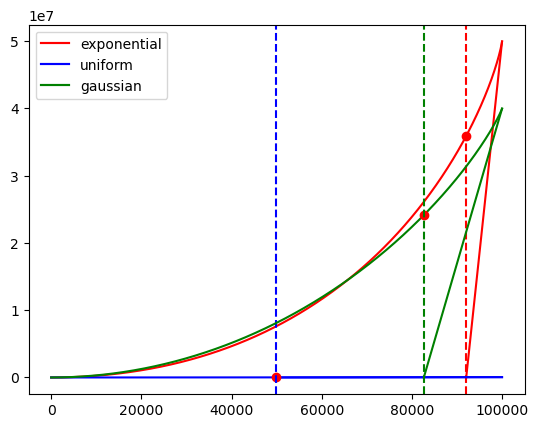

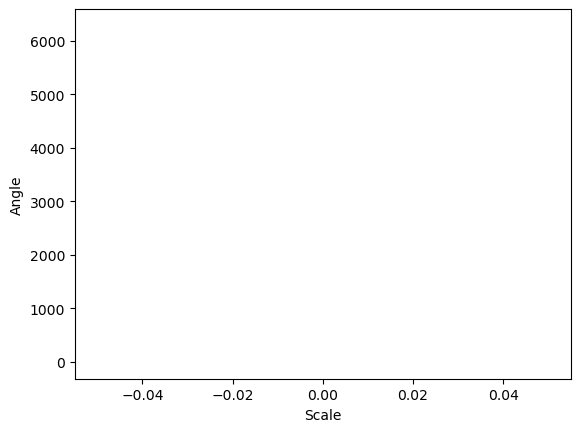

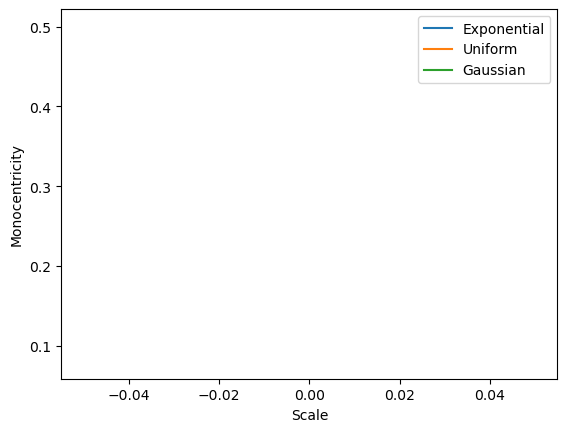

ValueError: x and y must be the same size

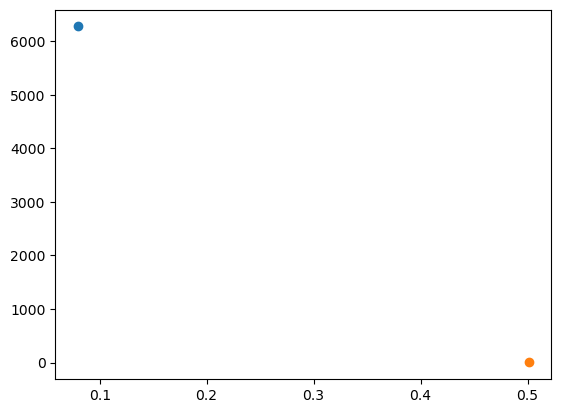

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import truncnorm
label2color = {'exponential':'r','uniform':'b','gaussian':'g'}
def PlotLorenzCurve(cumulative,Fstar,label2color,label):
    line1, = plt.plot(np.arange(len(cumulative)),cumulative,c=label2color[label],label=label)
    # Plot the straight line to F*
    line2, = plt.plot([Fstar, len(cumulative)], [0, cumulative[-1]], color=label2color[label],label = label + ' angle')
    plt.plot(Fstar,cumulative[Fstar],'ro',label=label + ' F*')
    plt.axvline(x=Fstar, color=label2color[label], linestyle='--')
    return line1,line2
def LorenzCenters(potential):
    '''
        Input:
            Potential from grid.
        This function computes the indices of the centers in the linearized grid.
        We are using here the index column and not the double index.
    '''
    # Step 1: Sort the potential and compute the sorting map
    sorted_indices = np.argsort(potential)
    # Step 2: Compute the cumulative distribution
    sorted_potential = potential[sorted_indices]
    cumulative = np.cumsum(sorted_potential)
    # Step 3: Determine the angle and delta index
    angle = cumulative[-1] - cumulative[-2]
    Fstar = int(len(cumulative) + 1 - cumulative[-1]/angle)
#    plt.show()
    # Step 4: Retrieve the indices based on the delta index and mapping
    result_indices = [sorted_indices[-i] for i in range(len(cumulative) - Fstar)]

    return result_indices,angle,cumulative,Fstar

# Example usage:
angle_uniform = []
monocentricity_uniform = []
angle_gaussian = []
monocentricity_gaussian = []
angle_exponential = []
monocentricity_exponential = []
lines = []
scale = 500
potential = np.random.exponential(scale,100000)  # Example potential
result_indices,angle,cumulative,Fstar = LorenzCenters(potential)    
lines.append(PlotLorenzCurve(cumulative,Fstar,label2color,'exponential'))

angle_exponential.append(angle)
monocentricity_exponential.append(len(result_indices)/len(potential))
potential = np.random.uniform(0,1,100000)  # Example potential
result_indices,angle,cumulative,Fstar = LorenzCenters(potential)
lines.append(PlotLorenzCurve(cumulative,Fstar,label2color,'uniform'))
angle_uniform.append(angle)
monocentricity_uniform.append(len(result_indices)/len(potential))
mean = 0.5
a = 0
potential = truncnorm.rvs(a=(a - mean) / scale, b = np.inf,scale=scale, loc=mean, size=len(potential))  # Example potential
result_indices,angle,cumulative,Fstar = LorenzCenters(potential)
lines.append(PlotLorenzCurve(cumulative,Fstar,label2color,'gaussian'))
angle_gaussian.append(angle)
#    print("Percentage Centers:", len(result_indices)/len(potential))
#    print("Result potential:", potential[result_indices])
labels = [line.get_label() for line, _ in lines]
plt.legend(lines, labels)
plt.show()

plt.plot(np.arange(len(angle_exponential)),angle_exponential)
plt.plot(np.arange(len(angle_uniform)),angle_uniform)
plt.plot(np.arange(len(angle_gaussian)),angle_gaussian)
plt.xlabel('Scale')
plt.ylabel('Angle')
plt.show()
plt.plot(np.arange(len(monocentricity_exponential)),monocentricity_exponential)
plt.plot(np.arange(len(monocentricity_uniform)),monocentricity_uniform)
plt.plot(np.arange(len(monocentricity_gaussian)),monocentricity_gaussian)
plt.xlabel('Scale')
plt.ylabel('Monocentricity')
plt.legend(['Exponential','Uniform','Gaussian'])
plt.show()

plt.scatter(monocentricity_exponential,angle_exponential)
plt.scatter(monocentricity_uniform,angle_uniform)
plt.scatter(monocentricity_gaussian,angle_gaussian)
plt.xlabel('Monocentricity')
plt.ylabel('Angle')
plt.legend(['Exponential','Uniform','Gaussian'])
plt.show()

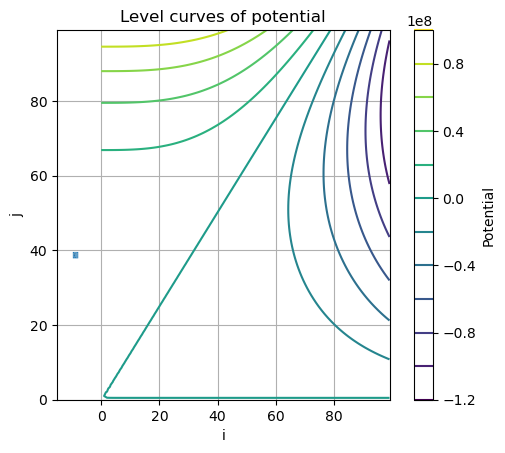

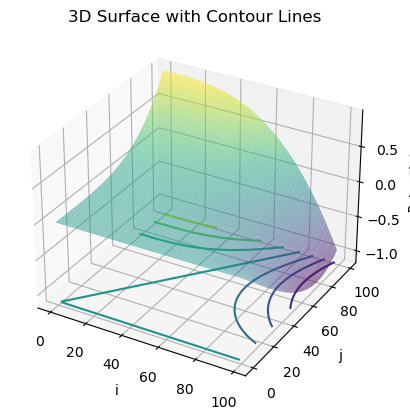

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import geopandas as gpd
LIS_polygon_file = '/home/aamad/Desktop/phd/berkeley/traffic_phase_transition/data/carto/LIS/shape_files/LIS.shp'
LIS_polygon = gpd.read_file(LIS_polygon_file)
file_graphml = '/home/aamad/Desktop/phd/berkeley/traffic_phase_transition/data/carto/LIS/LIS_new_tertiary_simplified.graphml'
LIS_polygon.plot()#(ax=ax, facecolor='none', edgecolor='red')
file = '/home/aamad/Desktop/phd/berkeley/traffic_phase_transition/data/carto/LIS/od_demand_7to8_R_1.fma'


Nx = 100
Ny = 100
# Example data
def circularpotential(x,y):
    return x**2 + y**2
potential = np.array([i**4 + j**3 - 2*(i*j**3)  for i in range(Nx) for j in range(Ny)])  # Example potential values
grid_shape = (Nx, Ny)  # Example grid shape
idx2grid = {i+j:(i,j) for i in range(Nx) for j in range(Ny)}  # Example map

# Reshape potential to match grid shape
potential_grid = potential.reshape(grid_shape)
# Create grid indices
i_indices, j_indices = np.meshgrid(np.arange(grid_shape[0]), np.arange(grid_shape[1]))

# Plot level curves
plt.contour(i_indices, j_indices, potential_grid, levels=10)  # Adjust levels as needed
plt.xlabel('i')
plt.ylabel('j')
plt.title('Level curves of potential')
plt.colorbar(label='Potential')
plt.grid(True)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(i_indices, j_indices, potential_grid, cmap='viridis', alpha=0.5)  # Adjust colormap and alpha as needed
# Plot contour lines on the XY plane
cset = ax.contour(i_indices, j_indices, potential_grid, zdir='z', offset=np.min(potential_grid), cmap='viridis')  # Adjust colormap as needed

# Set labels and title
ax.set_xlabel('i')
ax.set_ylabel('j')
ax.set_zlabel('Potential')
ax.set_title('3D Surface with Contour Lines')
#LIS_polygon.plot(ax = ax, facecolor='none', edgecolor='red')

plt.show()


In [ ]:
import os, glob, rasterio
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterio.mask import mask

def clip_raster_with_shp(input_shp, input_img_path, output_path, crs=None):

    '''Args
    - input_shp: .shp
    - input_img_path: Path to the image file (.tif)
    - output_path: Path to where you will save the clipped image file (.tif)
    '''

    # Load the raster image
    src = rasterio.open(input_img_path)

    # Clip the raster image using the shapefile geometry
    clipped_images, clipped_transforms = mask(src, input_shp.geometry, crop=True)

    # Update the metadata for the clipped raster
    clipped_meta = src.meta.copy()
    clipped_meta.update({
        "driver": "GTiff",
        "height": clipped_images.shape[1],
        "width": clipped_images.shape[2],
        "transform": clipped_transforms,
        "crs": crs,
        "nodata": np.nan
    })

    # Save the clipped raster image
    with rasterio.open(output_path, 'w', **clipped_meta) as dst:
        for band_idx in range(clipped_images.shape[0]):
            dst.write(clipped_images[band_idx], band_idx + 1)


# Set paths
BASE_PATH = '/home/minho/research/ocr/alberto'

img_paths = glob.glob(os.path.join(BASE_PATH, '*.tif'))
shp_paths = glob.glob(os.path.join(BASE_PATH, '*.shp'))

print(img_paths)

# Crop (Check for matching CRS)
if meta['crs'] == shpfile.crs:
    clip_raster_with_shp(shpfile, img_paths[1], img_paths[1].replace('.tif', '_cropped.tif'), crs='EPSG:4326')